In [1]:
import re
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import pandas as pd

cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram',
                                            binary=False, unicode_errors='ignore')


KeyedVectors<vector_size=300, 259936 keys>


In [11]:
train_set_sample = pd.read_csv("analyze_data.csv")

In [12]:
x = train_set_sample.loc[:,'comment']
y = train_set_sample.loc[:,'rating']
x_tokens = []
for text in x:
    # 使用jieba进行分词
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    x_tokens.append(cut_list)

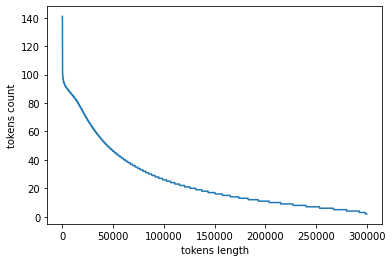

71.07059513583735


In [13]:
# 获取每段语句的长度，并画图展示
tokens_count = [len(tokens) for tokens in x_tokens]
tokens_count.sort(reverse=True)
# 画图查看词的长度分布
plt.plot(tokens_count)
plt.ylabel('tokens count')
plt.xlabel('tokens length')
plt.show()

#近似正态分布，长度定为平均值+标准差
tokens_length = np.mean(tokens_count) + 2 * np.std(tokens_count)
print(tokens_length)

In [14]:
embedding_matrix = np.zeros((50000, 300))
for i in range(50000):
    embedding_matrix[i, :] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

x_tokens_pad = tf.keras.preprocessing.sequence.pad_sequences(x_tokens,
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')
x_tokens_pad[x_tokens_pad >= 50000] = 0

In [17]:
x_tokens_train, x_tokens_test, y_tokens_train, y_tokens_test = train_test_split(
    x_tokens_pad,
    y,
    test_size=0.1,
    random_state=12
)

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000,300,
                                         weights=[embedding_matrix],
                                         input_length=int(tokens_length),
                                         trainable=False                                        
                                        ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=96, return_sequences=True)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy']
             )


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000,300,
                                         weights=[embedding_matrix],
                                         input_length=int(tokens_length),
                                         trainable=False                                        
                                        ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=96, return_sequences=True)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy']
             )


In [78]:
from keras.callbacks import ModelCheckpoint

save_dir = os.path.join(os.getcwd(), 'saved_models/nlp')
filepath="model_{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_sparse_categorical_accuracy',verbose=1, 
                            save_best_only=True)
history = model.fit(x_tokens_train, 
          y_tokens_train,
          batch_size=256,
          epochs=10, 
          validation_split=0.1,
          validation_freq=1,
          callbacks=[checkpoint]
         )

Epoch 1/10
950/950 [==============================] - 246s 259ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.2606 - val_sparse_categorical_accuracy: 0.8902

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89019, saving model to D:\REPOS\jupyter\saved_models/nlp\model_01-0.89.hdf5
Epoch 2/10
950/950 [==============================] - 246s 259ms/step - loss: 0.2381 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.2428 - val_sparse_categorical_accuracy: 0.9001

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89019 to 0.90011, saving model to D:\REPOS\jupyter\saved_models/nlp\model_02-0.90.hdf5
Epoch 3/10
950/950 [==============================] - 246s 259ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.2541 - val_sparse_categorical_accuracy: 0.8943

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.90011
Epoch 4/10
950/950 [==============================] - 245s 258ms/step - loss: 

In [18]:
result = model.evaluate(x_tokens_test, y_tokens_test)
print(f'Accuracy : {result[1]}')

938/938 [==============================] - 20s 20ms/step - loss: 0.2495 - sparse_categorical_accuracy: 0.8968
Accuracy : 0.8968333601951599


In [21]:

#测试模型
def text_process(text):
    print(text)
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            cut_list[i] = 0
        pass
    tokens_pad = tf.keras.preprocessing.sequence.pad_sequences([cut_list],
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')
    # 大于50000的归0，不归0模型的使用会报错
    tokens_pad[tokens_pad >= 50000] = 0
    return tokens_pad
test_list = [
#输入想要测试的语句
]
for text in test_list:
    try:
        tokens_pad = text_process(text)
        result = model.predict(x=tokens_pad)
        print(result)
        if result[0][0] <= result[0][1]:
            print(f'正:{result[0][1]}')
        else:
            print(f'负:{result[0][0]}')
    except Exception as ex:
        print(ex.args)
        pass
    pass

今天也是好天气
[[0.1361304  0.86386955]]
正:0.8638695478439331
这件事出的真是让人气愤！
[[0.6782131  0.32178685]]
负:0.6782131195068359


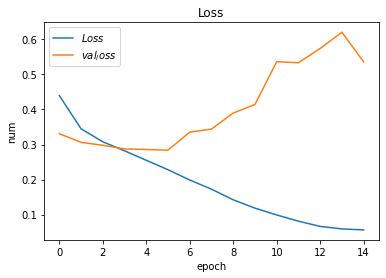

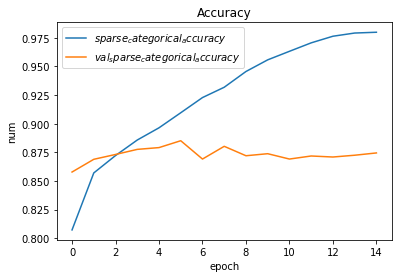

In [61]:
plt.plot(history.history['loss'],label="$Loss$")
plt.plot(history.history['val_loss'],label='$val_loss$')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'],label="$sparse_categorical_accuracy$")
plt.plot(history.history['val_sparse_categorical_accuracy'],label='$val_sparse_categorical_accuracy$')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()

In [23]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 71, 300)           15000000  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 71, 192)           304896    
_________________________________________________________________
lstm_19 (LSTM)               (None, 16)                13376     
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 96)                1632      
_________________________________________________________________
dropout_19 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)               